# Feature Analysis

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# So we have two medium-sized datasets with a lot of columns. Train and test data have similar number of rows
# Most of columns have missing data, which is normal in real world. Also there are columns with one unique value (or all missing). There are a lot of continuous variables and some categorical.
# Some of features seem to be normalized. So if someone wants to normalize all variables, it would be necessary to separate such variables which seem to be already normalized.
# A very important idea: it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation. This was already noted in abother kernel: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# folder_path = '../input/ieee-fraud-detection/'
folder_path = '../data/'

print('Loading data...')

train_identity = pd.read_csv(f'{folder_path}train_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_identity!')

train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_transaction!')

test_identity = pd.read_csv(f'{folder_path}test_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_identity!')

test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_transaction!')

sub = pd.read_csv(f'{folder_path}sample_submission.csv')
print('\tSuccessfully loaded sample_submission!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_transaction!
	Successfully loaded test_identity!
	Successfully loaded test_transaction!
	Successfully loaded sample_submission!
Data was successfully loaded!



In [5]:
# train_identity.head(5)

In [9]:
train_identity['has_id']=1
train=train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)

In [11]:
test_identity['had_id']=1
test=test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

(array([2.0000e+00, 1.0000e+00, 6.0000e+00, 0.0000e+00, 7.0000e+00,
        1.2000e+01, 4.4000e+01, 1.8000e+01, 2.0000e+01, 2.8000e+01,
        3.0000e+01, 2.8000e+01, 9.3000e+01, 1.5000e+02, 7.9000e+01,
        1.1300e+02, 1.2000e+02, 4.9200e+02, 3.5800e+02, 8.0200e+02,
        6.1900e+02, 8.1400e+02, 1.2890e+03, 1.2830e+03, 1.7170e+03,
        2.4930e+03, 1.9040e+03, 2.2040e+03, 2.1940e+03, 5.5110e+03,
        3.6330e+03, 3.0290e+03, 5.2670e+03, 4.8360e+03, 5.7700e+03,
        1.7742e+04, 1.3609e+04, 1.4109e+04, 1.9210e+04, 1.5108e+04,
        7.5380e+03, 7.9910e+03, 4.2336e+04, 1.0556e+04, 5.5126e+04,
        8.9800e+03, 8.3190e+03, 1.6400e+04, 1.1158e+04, 2.6204e+04,
        3.1128e+04, 2.8785e+04, 4.9320e+03, 6.9420e+03, 1.6856e+04,
        9.2960e+03, 2.4700e+03, 1.5333e+04, 1.4108e+04, 5.0990e+03,
        5.4360e+03, 3.6800e+03, 1.0622e+04, 1.8960e+03, 3.2150e+03,
        4.7770e+03, 1.5800e+03, 3.6740e+03, 3.5700e+03, 1.5540e+03,
        1.5170e+03, 1.5340e+03, 9.7400e+02, 8.49

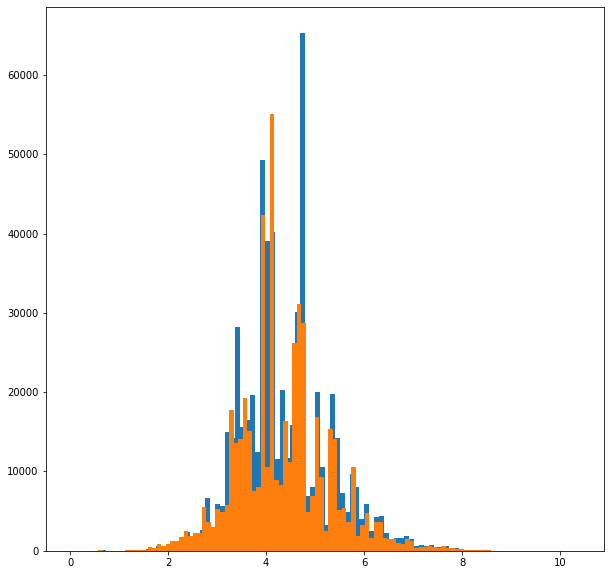

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.hist(np.log1p(train_transaction.TransactionAmt),bins=100)
plt.hist(np.log1p(test_transaction.TransactionAmt),bins=100)

(array([9.0000e+00, 1.3000e+01, 1.3000e+01, 6.0000e+00, 1.4000e+02,
        1.6000e+01, 1.6000e+01, 1.4000e+01, 1.5000e+01, 7.8000e+01,
        9.3000e+01, 8.8000e+01, 1.0600e+02, 2.6000e+02, 3.3300e+02,
        5.7100e+02, 4.4900e+02, 8.8800e+02, 6.7600e+02, 1.2930e+03,
        1.1690e+03, 2.4050e+03, 1.8750e+03, 2.1730e+03, 2.5600e+03,
        6.6570e+03, 2.6240e+03, 5.8440e+03, 5.6960e+03, 1.5040e+04,
        1.4286e+04, 2.8172e+04, 1.5669e+04, 1.6486e+04, 1.9629e+04,
        1.2410e+04, 4.9271e+04, 3.9062e+04, 4.0203e+04, 1.1567e+04,
        2.0220e+04, 1.1667e+04, 1.5907e+04, 3.0099e+04, 6.5282e+04,
        6.8810e+03, 8.0670e+03, 2.0041e+04, 1.0528e+04, 3.2410e+03,
        1.9786e+04, 1.4248e+04, 7.2530e+03, 4.8790e+03, 9.7230e+03,
        8.0670e+03, 4.0460e+03, 5.8540e+03, 2.4360e+03, 4.2660e+03,
        4.3800e+03, 2.2170e+03, 1.3810e+03, 1.5790e+03, 1.6180e+03,
        1.9010e+03, 1.5500e+03, 5.7300e+02, 6.6900e+02, 6.5300e+02,
        7.8000e+02, 4.9800e+02, 5.2900e+02, 5.51

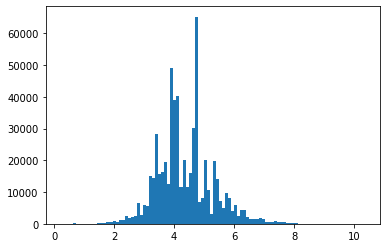

In [43]:
plt.hist(np.log1p(train_transaction.TransactionAmt),bins=100)

(array([2.0000e+00, 1.0000e+00, 6.0000e+00, 0.0000e+00, 7.0000e+00,
        1.2000e+01, 4.4000e+01, 1.8000e+01, 2.0000e+01, 2.8000e+01,
        3.0000e+01, 2.8000e+01, 9.3000e+01, 1.5000e+02, 7.9000e+01,
        1.1300e+02, 1.2000e+02, 4.9200e+02, 3.5800e+02, 8.0200e+02,
        6.1900e+02, 8.1400e+02, 1.2890e+03, 1.2830e+03, 1.7170e+03,
        2.4930e+03, 1.9040e+03, 2.2040e+03, 2.1940e+03, 5.5110e+03,
        3.6330e+03, 3.0290e+03, 5.2670e+03, 4.8360e+03, 5.7700e+03,
        1.7742e+04, 1.3609e+04, 1.4109e+04, 1.9210e+04, 1.5108e+04,
        7.5380e+03, 7.9910e+03, 4.2336e+04, 1.0556e+04, 5.5126e+04,
        8.9800e+03, 8.3190e+03, 1.6400e+04, 1.1158e+04, 2.6204e+04,
        3.1128e+04, 2.8785e+04, 4.9320e+03, 6.9420e+03, 1.6856e+04,
        9.2960e+03, 2.4700e+03, 1.5333e+04, 1.4108e+04, 5.0990e+03,
        5.4360e+03, 3.6800e+03, 1.0622e+04, 1.8960e+03, 3.2150e+03,
        4.7770e+03, 1.5800e+03, 3.6740e+03, 3.5700e+03, 1.5540e+03,
        1.5170e+03, 1.5340e+03, 9.7400e+02, 8.49

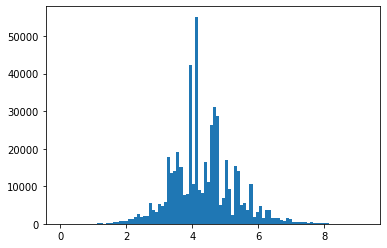

In [44]:
plt.hist(np.log1p(test_transaction.TransactionAmt),bins=100)

In [18]:
from scipy.stats import ks_2samp
def corr(train, test, cols):
    # assuming first column is `class_name_id`


    for class_name in cols:
        # all correlations
        print('\n Class: %s' % class_name)

        ks_stat, p_value = ks_2samp(train[class_name].values,
                                    test[class_name].values)
        print(' Kolmogorov-Smirnov test:    KS-stat = %.6f    p-value = %.3e\n'
              % (ks_stat, p_value))

In [19]:
corr(train,test,['TransactionAmt'])


 Class: TransactionAmt
 Kolmogorov-Smirnov test:    KS-stat = 0.017615    p-value = 6.158e-74



In [31]:
train_transaction.dtypes

isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 393, dtype: object

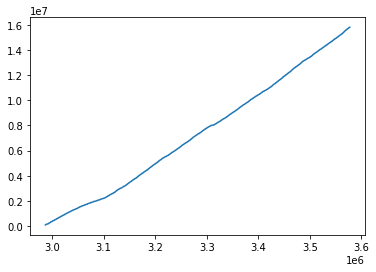

In [33]:
train_feature_to_eda=None
train_feature_to_eda=train_transaction.TransactionDT
plt.plot(train_feature_to_eda)

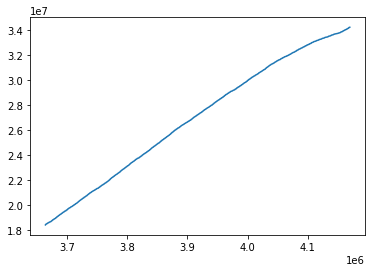

In [34]:
test_feature_to_eda=None
test_feature_to_eda=test_transaction.TransactionDT
plt.plot(test_feature_to_eda)

In [35]:
train=pd.DataFrame()
train['time'] = pd.to_datetime(train_transaction['TransactionDT']+1546272000, unit='s')#2019.01.01 0:0:0偏移
train['year'] = train["time"].dt.year
train['month'] = train["time"].dt.month
train['day'] = train["time"].dt.day
train['hour']  = train["time"].dt.hour
train['minute']  = train["time"].dt.minute
train['weekday']  = train["time"].dt.dayofweek
train.pop('time')


test=pd.DataFrame()
test['time'] = pd.to_datetime(test_transaction['TransactionDT']+1546272000, unit='s')#2019.01.01 0:0:0偏移
test['year'] = test["time"].dt.year
test['month'] = test["time"].dt.month
test['day'] = test["time"].dt.day
test['hour']  = test["time"].dt.hour
test['minute']  = test["time"].dt.minute
test['weekday']  = test["time"].dt.dayofweek
test.pop('time')

TransactionID
3663549   2019-08-01 16:00:24
3663550   2019-08-01 16:01:03
3663551   2019-08-01 16:01:50
3663552   2019-08-01 16:01:50
3663553   2019-08-01 16:01:57
                  ...        
4170235   2020-01-31 15:57:59
4170236   2020-01-31 15:58:07
4170237   2020-01-31 15:58:46
4170238   2020-01-31 15:58:57
4170239   2020-01-31 15:59:05
Name: time, Length: 506691, dtype: datetime64[ns]

In [36]:
from scipy.stats import ks_2samp

from scipy.stats import ks_2samp

def corr(train, test,cols):
    # assuming first column is `class_name_id`


    for class_name in cols:
        # all correlations
        print('\n Class: %s' % class_name)

        ks_stat, p_value = ks_2samp(train[class_name].values,
                                    test[class_name].values)
        print(' Kolmogorov-Smirnov test:    KS-stat = %.6f    p-value = %.3e\n'
              % (ks_stat, p_value))

corr(train, test,cols=['year','month','day','hour','minute','weekday'])
corr(train, test,cols=['year','month','day','hour','minute','weekday'])


 Class: year
 Kolmogorov-Smirnov test:    KS-stat = 0.235465    p-value = 0.000e+00


 Class: month
 Kolmogorov-Smirnov test:    KS-stat = 0.764535    p-value = 0.000e+00


 Class: day
 Kolmogorov-Smirnov test:    KS-stat = 0.025674    p-value = 1.368e-156


 Class: hour
 Kolmogorov-Smirnov test:    KS-stat = 0.017204    p-value = 1.529e-70


 Class: minute
 Kolmogorov-Smirnov test:    KS-stat = 0.002595    p-value = 5.066e-02


 Class: weekday
 Kolmogorov-Smirnov test:    KS-stat = 0.016545    p-value = 2.826e-65


 Class: year
 Kolmogorov-Smirnov test:    KS-stat = 0.235465    p-value = 0.000e+00


 Class: month
 Kolmogorov-Smirnov test:    KS-stat = 0.764535    p-value = 0.000e+00


 Class: day
 Kolmogorov-Smirnov test:    KS-stat = 0.025674    p-value = 1.368e-156


 Class: hour
 Kolmogorov-Smirnov test:    KS-stat = 0.017204    p-value = 1.529e-70


 Class: minute
 Kolmogorov-Smirnov test:    KS-stat = 0.002595    p-value = 5.066e-02


 Class: weekday
 Kolmogorov-Smirnov test:   

In [37]:
train.year.value_counts()
test.year.value_counts()

2019    387383
2020    119308
Name: year, dtype: int64

In [38]:
train.month.value_counts()
test.month.value_counts()

1     119308
12     84685
11     77510
8      76379
10     75072
9      73737
Name: month, dtype: int64

In [ ]:

label_col = 'isFraud'
drop_fea = ['isFraud']
feature = [x for x in train_df.columns if x not in drop_fea]

params = {'num_leaves': 60,
      'min_data_in_leaf': 30,
      'objective': 'binary', 
      'max_depth': -1,
      'learning_rate': 0.06,
      "min_sum_hessian_in_leaf": 6,
      "boosting": "gbdt",
      "feature_fraction": 0.9,  
      "bagging_freq": 1,
      "bagging_fraction": 0.8,
      "bagging_seed": 11,
      "lambda_l1": 0.1,             
      "verbosity": -1,
      "nthread": -1,                
      'metric': {'binary_logloss', 'auc'},  
      "random_state": 2019, 
      }

trn_data = lgb.Dataset(train_df[feature], label=train_df[label_col])
val_data = lgb.Dataset(valid_df[feature], label=valid_df[label_col])


clf = lgb.train(params,
                trn_data,
                1000,
                valid_sets=[trn_data, val_data],
                verbose_eval=20,
                early_stopping_rounds=60)

##Prediction

y_pre = clf.predict(train_df[feature], num_iteration=clf.best_iteration)
train_acc = accuracy_score(train_df[label_col],y_pre>0.5)
train_f1 = f1_score(train_df[label_col],y_pre>0.5)
train_recall = recall_score(train_df[label_col],y_pre>0.5)
train_precision = precision_score(train_df[label_col],y_pre>0.5)

y_pre = clf.predict(valid_df[feature], num_iteration=clf.best_iteration)
valid_acc = accuracy_score(valid_df[label_col],y_pre>0.5)
valid_f1 = f1_score(valid_df[label_col],y_pre>0.5)
valid_recall = recall_score(valid_df[label_col],y_pre>0.5)
valid_precision = precision_score(valid_df[label_col],y_pre>0.5)

y_pre = clf.predict(test_df[feature], num_iteration=clf.best_iteration)
test_acc = accuracy_score(test_df[label_col],y_pre>0.5)
test_f1 = f1_score(test_df[label_col],y_pre>0.5)
test_recall = recall_score(test_df[label_col],y_pre>0.5)
test_precision = precision_score(test_df[label_col],y_pre>0.5)


Training until validation scores don't improve for 60 rounds
[20]	training's binary_logloss: 0.096159	training's auc: 0.891049	valid_1's binary_logloss: 0.0983097	valid_1's auc: 0.884045
[40]	training's binary_logloss: 0.0844877	training's auc: 0.912664	valid_1's binary_logloss: 0.0880086	valid_1's auc: 0.902097
[60]	training's binary_logloss: 0.0778596	training's auc: 0.925243	valid_1's binary_logloss: 0.082508	valid_1's auc: 0.912314
[80]	training's binary_logloss: 0.0733062	training's auc: 0.934439	valid_1's binary_logloss: 0.0790051	valid_1's auc: 0.919076
[100]	training's binary_logloss: 0.0696292	training's auc: 0.941687	valid_1's binary_logloss: 0.0763363	valid_1's auc: 0.924717
[120]	training's binary_logloss: 0.0666864	training's auc: 0.947398	valid_1's binary_logloss: 0.0741218	valid_1's auc: 0.929462
[140]	training's binary_logloss: 0.0643045	training's auc: 0.951267	valid_1's binary_logloss: 0.0723909	valid_1's auc: 0.932432
[160]	training's binary_logloss: 0.0622198	traini

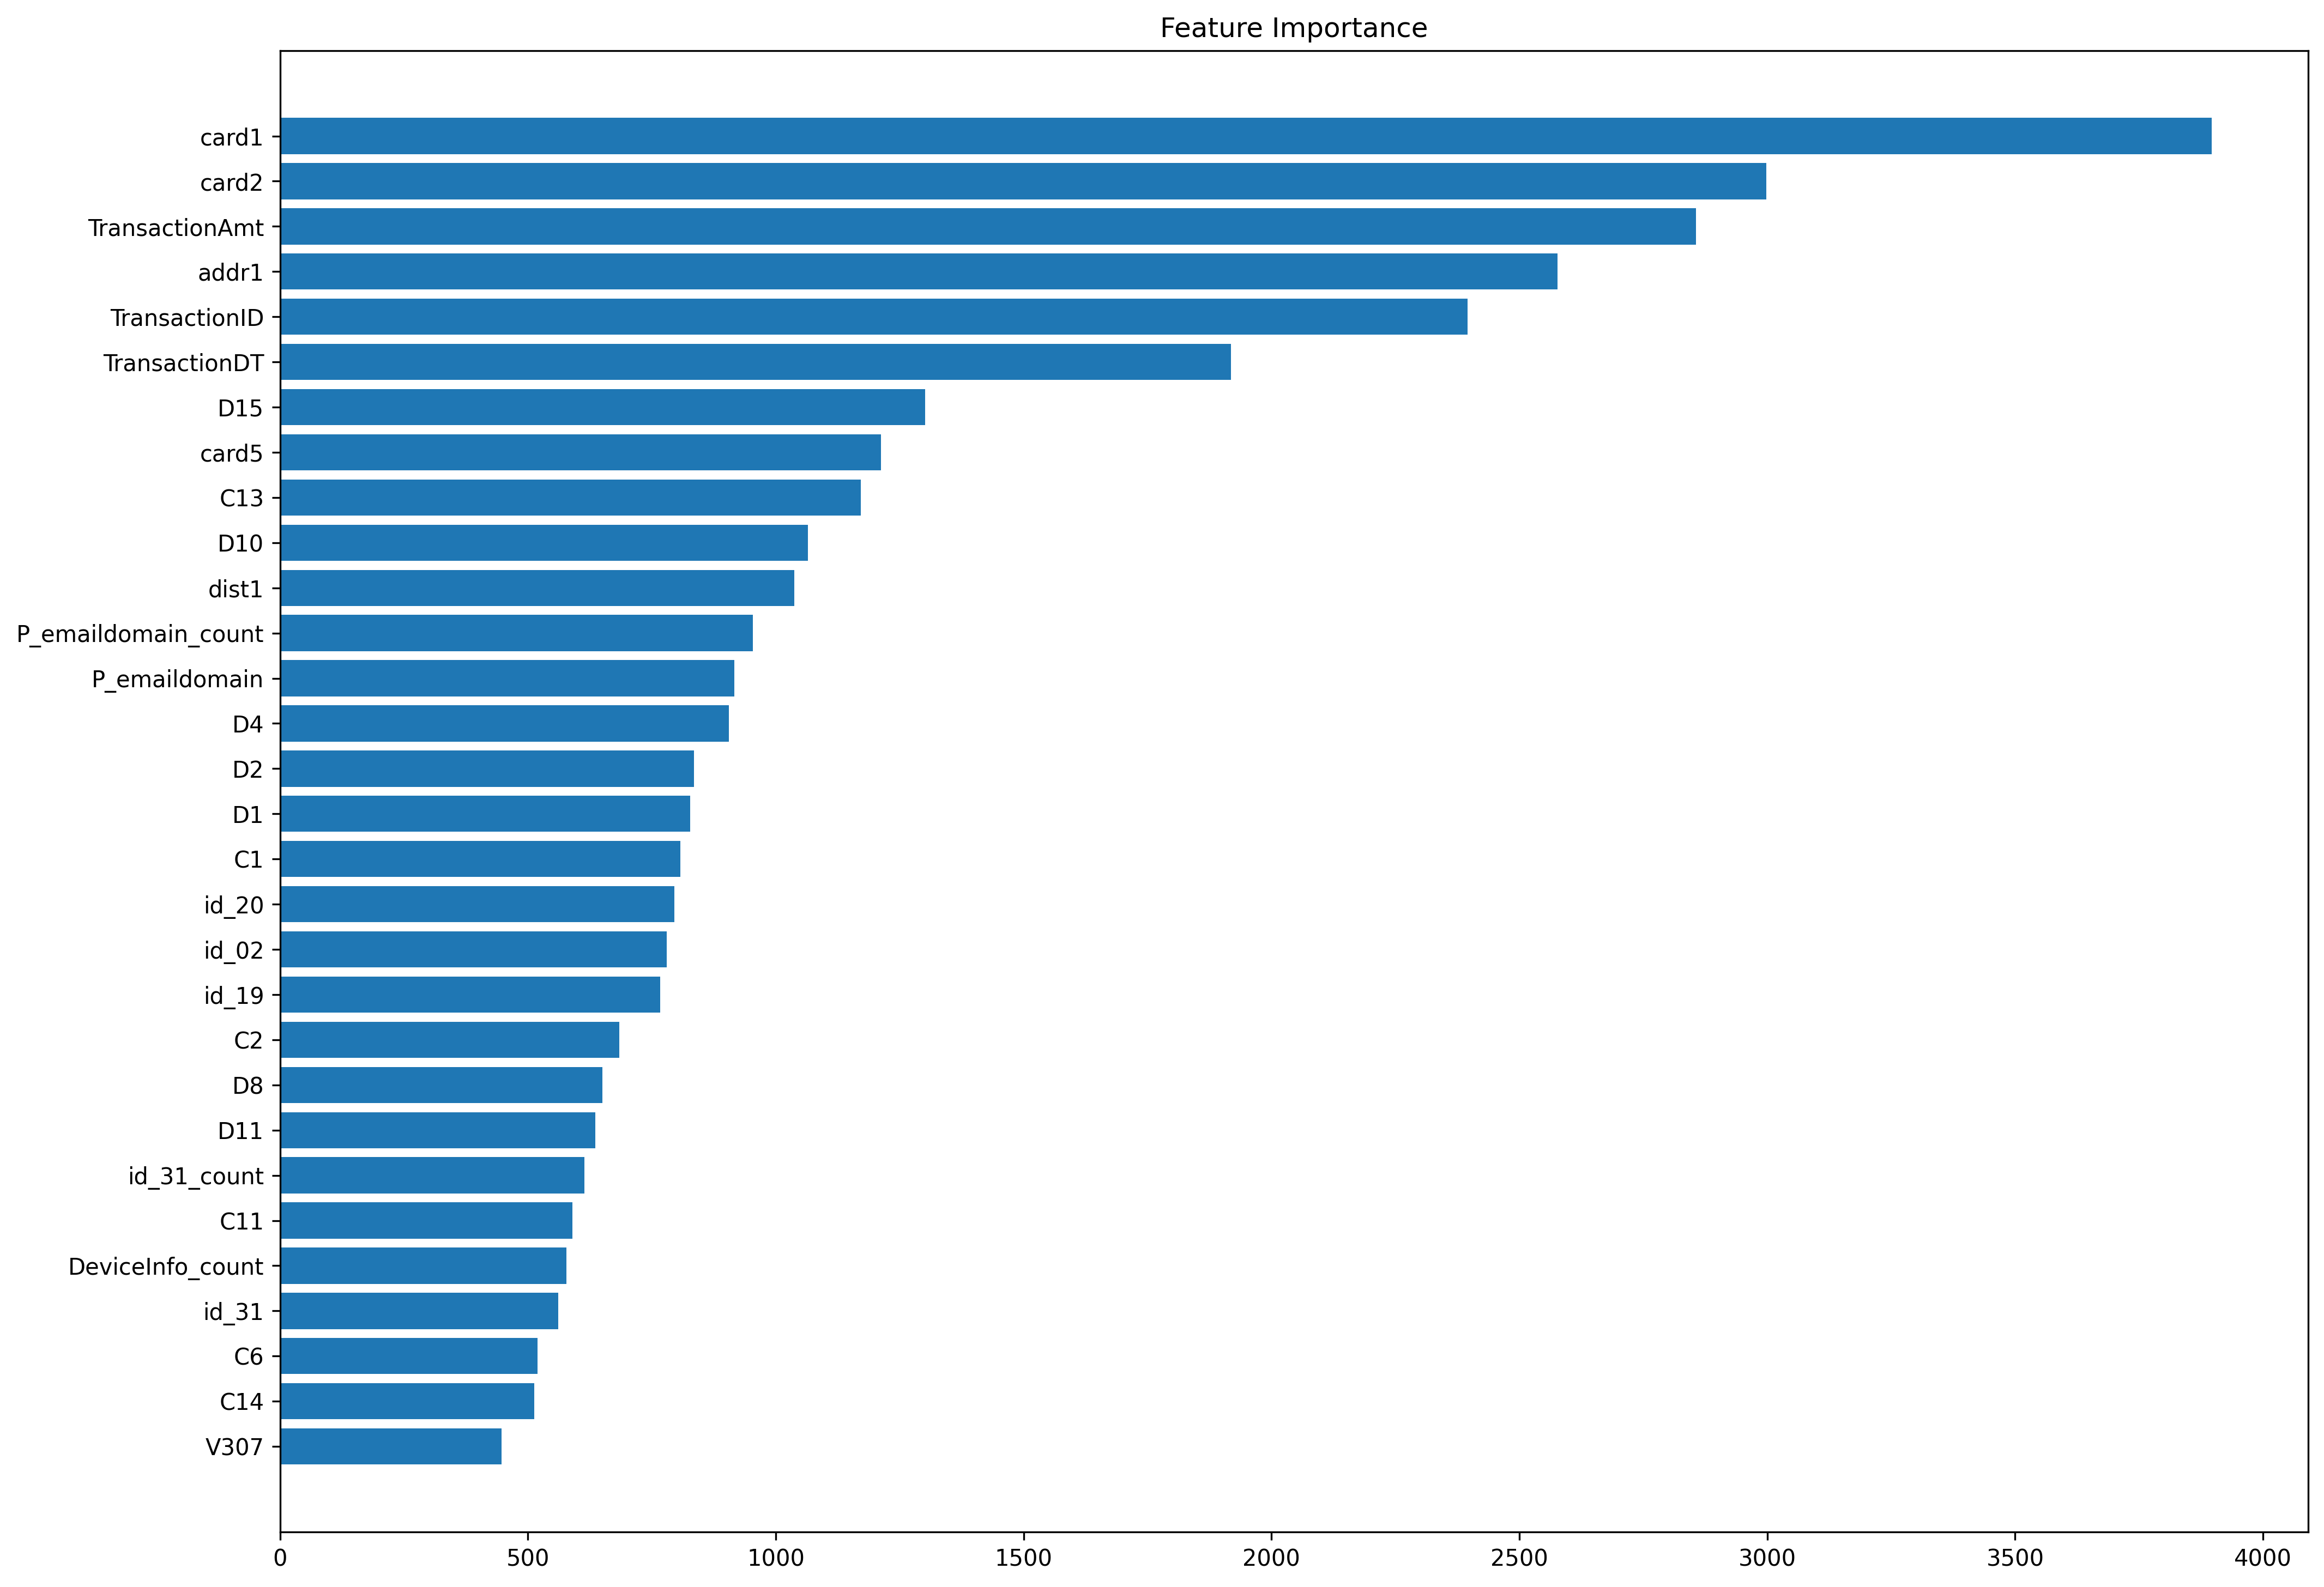

<Figure size 432x288 with 0 Axes>

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = feature
feature_importance['fea_imp']  = clf.feature_importance()
feature_importance             = feature_importance.sort_values('fea_imp',ascending = True)
feature_importance = feature_importance[-30:]

plt.figure(dpi=300,figsize=(16,12))
plt.barh(y =[i for i in range(1,len(feature_importance)+1)], width = feature_importance['fea_imp'])
plt.yticks([i for i in range(1,len(feature_importance)+1)],feature_importance['fea_name'])
plt.title('Feature Importance')
plt.show()
plt.savefig('../pic/lgb_feature.jpg')